In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data_path = "/kaggle/input/rock-paper-scissors/train"
test_data_path = "/kaggle/input/rock-paper-scissors/test"


# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=test_data_path,
    transform=test_transform
)


Computing dataset statistics...


In [11]:

BATCH_SIZE = 32  
NUM_EPOCHS = 20
NUM_CLASSES = 3

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [12]:

# Define model architecture
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(150*150*3, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASSES)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
model = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training and validation loop
def train_model():
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_accuracy = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(test_loader.dataset)
        val_epoch_acc = correct / total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        scheduler.step(val_epoch_loss)
        
        # Save best model
        if val_epoch_acc > best_accuracy:
            best_accuracy = val_epoch_acc
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        print('-' * 50)
    
    return train_losses, val_losses, val_accuracies


In [13]:
# Execute training
train_loss, val_loss, val_acc = train_model()

Epoch 1/20
Train Loss: 2.7255 | Val Loss: 1.0890 | Val Acc: 0.4812
--------------------------------------------------
Epoch 2/20
Train Loss: 0.8321 | Val Loss: 0.9601 | Val Acc: 0.6048
--------------------------------------------------
Epoch 3/20
Train Loss: 0.6804 | Val Loss: 0.8601 | Val Acc: 0.6075
--------------------------------------------------
Epoch 4/20
Train Loss: 0.4963 | Val Loss: 0.6304 | Val Acc: 0.7984
--------------------------------------------------
Epoch 5/20
Train Loss: 0.4125 | Val Loss: 0.7138 | Val Acc: 0.7177
--------------------------------------------------
Epoch 6/20
Train Loss: 0.3606 | Val Loss: 0.4965 | Val Acc: 0.7581
--------------------------------------------------
Epoch 7/20
Train Loss: 0.3426 | Val Loss: 0.5685 | Val Acc: 0.8038
--------------------------------------------------
Epoch 8/20
Train Loss: 0.3007 | Val Loss: 0.5396 | Val Acc: 0.8091
--------------------------------------------------
Epoch 9/20
Train Loss: 0.2638 | Val Loss: 0.6471 | Val A


Final Test Accuracy: 0.8360


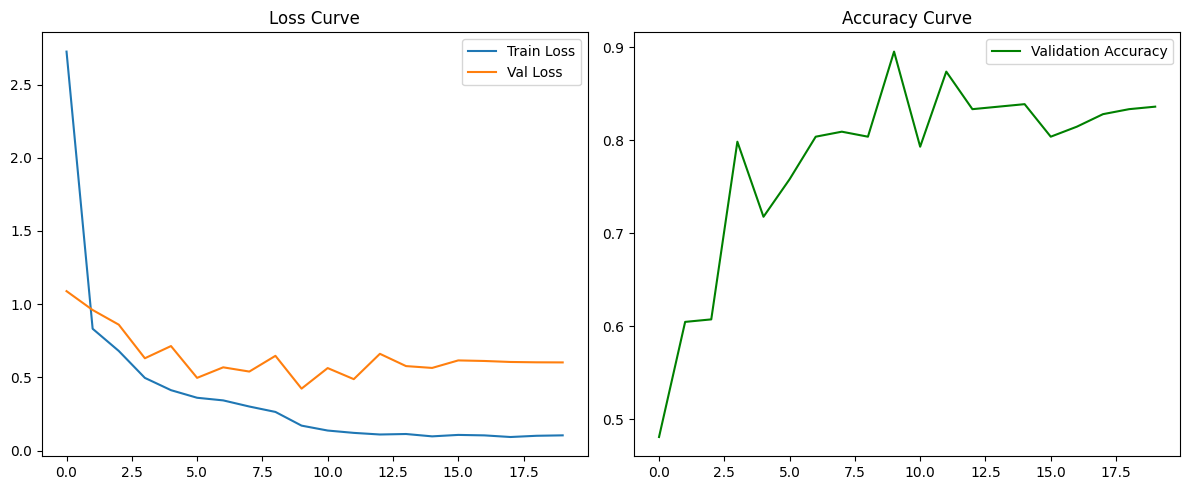

In [14]:
# Final evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nFinal Test Accuracy: {correct/total:.4f}')

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Validation Accuracy', color='green')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

Computing dataset statistics...
Computed mean: [0.8506494164466858, 0.8218992352485657, 0.8120025396347046]
Computed std: [0.22173038125038147, 0.26626354455947876, 0.28147318959236145]
Epoch 1/100
Train Loss: 7.0958 | Val Accuracy: 0.8313
--------------------------------------------------
Epoch 2/100
Train Loss: 4.6139 | Val Accuracy: 0.8571
--------------------------------------------------
Epoch 3/100
Train Loss: 3.6498 | Val Accuracy: 0.9087
--------------------------------------------------
Epoch 4/100
Train Loss: 3.2252 | Val Accuracy: 0.9325
--------------------------------------------------
Epoch 5/100
Train Loss: 2.6854 | Val Accuracy: 0.9325
--------------------------------------------------
Epoch 6/100
Train Loss: 2.4376 | Val Accuracy: 0.9722
--------------------------------------------------
Epoch 7/100
Train Loss: 2.4713 | Val Accuracy: 0.9663
--------------------------------------------------
Epoch 8/100
Train Loss: 1.9935 | Val Accuracy: 0.9722
-------------------------

<ipython-input-17-3559446a4da4>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Accuracy: 0.7366


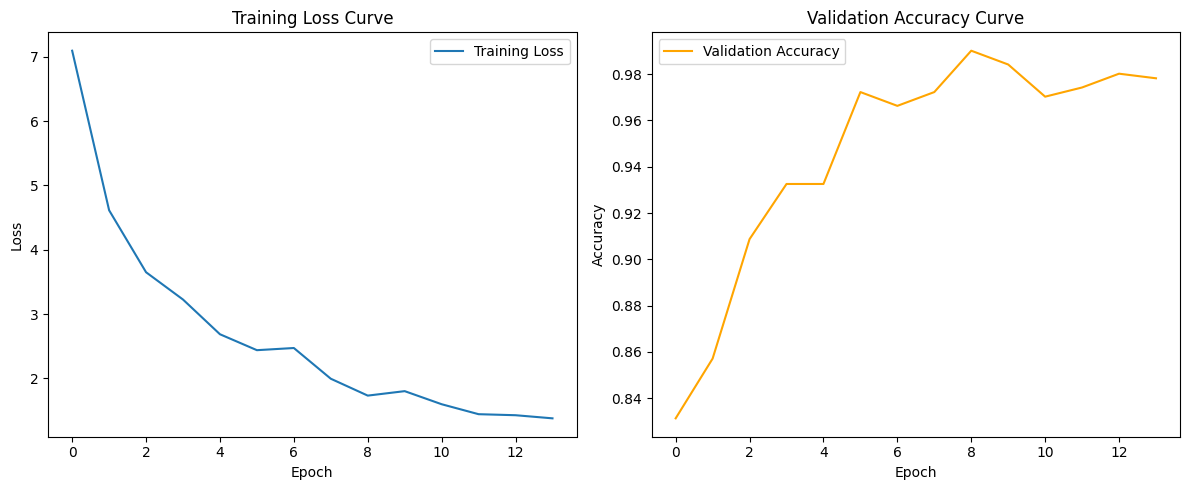

In [17]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration parameters
train_data_path = "/kaggle/input/rock-paper-scissors/train"
test_data_path = "/kaggle/input/rock-paper-scissors/test"
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64  # Increased batch size
NUM_EPOCHS = 100
INPUT_DIM = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3

# Step 1: Compute dataset statistics
print("Computing dataset statistics...")

temp_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

stats_dataset = datasets.ImageFolder(root=train_data_path, transform=temp_transform)
stats_loader = DataLoader(stats_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

mean, std, total_images = 0.0, 0.0, 0
for images, _ in stats_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images
print(f"Computed mean: {mean.tolist()}\nComputed std: {std.tolist()}")

# Step 2: Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Step 3: Create datasets
base_dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=transforms.Resize(IMAGE_SIZE)
)

train_size = int(0.80 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_subset, val_subset = random_split(base_dataset, [train_size, val_size])

class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

train_dataset = TransformSubset(train_subset, train_transform)
val_dataset = TransformSubset(val_subset, val_test_transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=val_test_transform)

# Step 4: Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Step 5: Simplified ANN Architecture
class RockPaperScissorsANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(INPUT_DIM, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            
            nn.Linear(256, 3)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

model = RockPaperScissorsANN().to(device)

# Step 6: Training Setup with Strong Regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0001,          # Reduced learning rate
    weight_decay=1e-3  # Increased weight decay
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=3,        # More responsive scheduler
    factor=0.2,
    verbose=True
)

# Step 7: Training Loop with Adjusted Early Stopping
best_accuracy = 0.0
patience_counter = 0
train_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    scheduler.step(val_accuracy)
    
    # Early Stopping
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:  # More aggressive stopping
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {epoch_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print('-' * 50)

# Final Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nFinal Test Accuracy: {correct/total:.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()